In [1]:
import torch
from torch import optim
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import os
import matplotlib.pyplot as plt


In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  # 对卷积层进行 He 初始化
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:  # 对 BatchNorm 层
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:  # 对全连接层
        nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')


class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # 残差连接
        out = self.relu(out)
        return out



class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # 残差连接
        return out

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

    def forward(self, x):
        # x shape: [batch_size, channels, height, width], need to reshape to [height * width, batch_size, channels]
        batch_size, channels, height, width = x.size()
        # print(x.size())
        x = x.view(batch_size, channels, -1).permute(2, 0, 1)  # [height * width, batch_size, channels]
        
        attn_output, _ = self.multihead_attn(x, x, x)  # Self-attention
        attn_output = attn_output.permute(1, 2, 0).view(batch_size, channels, height, width)  # Restore original shape
        return attn_output

class G(nn.Module):
    def __init__(self, in_dims=128):
        super(G, self).__init__()

        self.fn1 = nn.Sequential(
            nn.Linear(in_dims, 512 * 16*4),
            nn.BatchNorm1d(512 * 16*4),
            nn.ReLU()
        )

        self.initial_conv = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)
        self.BatchNorm2d1 = nn.BatchNorm2d(128)

        self.second_conv = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.BatchNorm2d2 = nn.BatchNorm2d(64)

        self.attention = MultiHeadAttentionLayer(embed_dim=64, num_heads=4)
        
        self.third_conv = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.BatchNorm2d3 = nn.BatchNorm2d(32)

        self.fourth_conv = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.BatchNorm2d4 = nn.BatchNorm2d(32)

        # 多头自注意力层
        

        # 增加更多残差块
        self.resblocks = nn.Sequential(
            ResBlock(32),
            ResBlock(32),
            ResBlock(32)
        )

        self.fifth_conv = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.BatchNorm2d5 = nn.BatchNorm2d(16)

        self.final_conv = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.apply(weights_init)

    def forward(self, x):
        z = self.fn1(x)
        z = z.view(-1, 128*4, 8, 8)  # 调整视图以匹配初始卷积层的输入
        
        z = self.initial_conv(z)
        z = self.BatchNorm2d1(z)
        z = nn.ReLU()(z)

        z = self.second_conv(z)
        z = self.BatchNorm2d2(z)
        z = nn.ReLU()(z)
        z = self.attention(z)

        z = self.third_conv(z)
        z = self.BatchNorm2d3(z)
        z = nn.ReLU()(z)

        z = self.fourth_conv(z)
        z = self.BatchNorm2d4(z)
        z = nn.ReLU()(z)

        # 应用多头自注意力
        # z = self.attention(z)

        # 使用多个残差块
        z = self.resblocks(z)

        z = self.fifth_conv(z)
        z = self.BatchNorm2d5(z)
        z = nn.ReLU()(z)

        z = self.final_conv(z)
        return self.tanh(z)

 
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 确保输入和输出通道匹配
        self.match_dimensions = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.match_dimensions is not None:
            identity = self.match_dimensions(identity)
        
        out += identity  # 残差连接
        out = self.relu(out)
        return out

class D(nn.Module):
    def __init__(self, in_dims=3, dims=32):
        super(D, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_dims, dims, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(dims),
            self.conv_binary_2d(dims, 4 * dims),
            # ResBlock2(2 * dims, 4 * dims),
            self.conv_binary_2d(4 * dims, 4 * dims),
            ResBlock2(4 * dims, 4 * dims),
            self.conv_binary_2d(4 * dims, 8 * dims),
            #ResBlock2(4 * dims, 8 * dims),
            self.conv_binary_2d(8 * dims, 8 * dims),
            #ResBlock2(8 * dims, 8 * dims),
            self.conv_binary_2d(8 * dims, 4 * dims),
            self.conv_binary_2d(4 * dims, dims),
            ResBlock2(dims, dims),
            nn.Conv2d(dims, 1, kernel_size=2*2)
        )

        self.sigm = nn.Sigmoid()
        self.apply(weights_init)

    def conv_binary_2d(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        z = self.model(x)
        z = z.view(-1)  # 确保这与预期的形状匹配
        z = self.sigm(z)
        return z
    

C:\Users\touka\AppData\Local\Temp\ipykernel_23960\2464266839.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_model.load_state_dict(torch.load('generator.pth'))


Models loaded successfully.


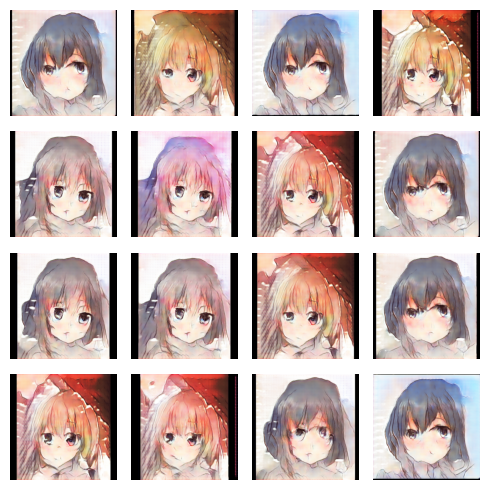

In [3]:
mode="TEST"
G_model = G(in_dims=128).cuda()
if mode == "TEST":
    # Load the models
    G_model.load_state_dict(torch.load('generator.pth'))
    # D_model.load_state_dict(torch.load('discriminator.pth'))
    print("Models loaded successfully.")
else:
    print("No saved models found. Starting training from scratch.")

device='cuda'



with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    fake_images = G_model(z).cpu()
    fake_images = (fake_images + 1) / 2  # Denormalize
    
    fig, axs = plt.subplots(4, 4, figsize=(5, 5))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(fake_images[i*4 + j].permute(1, 2, 0))
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(f'./logs/GAN_rem.png')
    plt.show()